In [1]:
%cd /home/q123/Desktop/explo

import torch 
import logging
import logging.config

import yaml

from src.config import insertion_config,insert
from src.helpers import setup_experiment
from src.trainer import Trainer
from src.gibo.optim import GIBOptimizer
from src.optim import BOptimizer

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

/home/q123/Desktop/explo


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Cartpole

# env_config = {
#         "reward_scale":500,
#         "reward_shift":0,
#         "env_name":"CartPole-v1",
# }

## Swimmer
env_config = {
        "reward_scale":350,
        "reward_shift":0,
        "env_name":"Swimmer-v2",
}

# ## hopper
# env_config = {
#         "reward_scale":1000,
#         "reward_shift":1,
#         "env_name":"Hopper-v2",
# }


In [3]:
kernel_name = "rbf"
n_init = 2

import gpytorch 

model_config = {
        
        ###### Cartpole
        
        # "ard_num_dims":5,
        # "N_max":20,
        
        ###### Hopper
        # "ard_num_dims":36,
        # "N_max":48,
        
        ##### Swimmer
        "ard_num_dims":18,
        "N_max":32,
        #########
        
        #"lengthscale_hyperprior":gpytorch.priors.torch_priors.NormalPrior(loc=2.0,scale=1.0),
        #"lengthscale_hyperprior":gpytorch.priors.torch_priors.UniformPrior(a=1,b=5),
        #"prior_mean":0,
        "lengthscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(3.0,6.0),
        "lengthscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.001),
        "outputscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.1),
        "outputscale_hyperprior":gpytorch.priors.torch_priors.NormalPrior(loc=2.0,scale=1.0),
        "noise_hyperprior":gpytorch.priors.torch_priors.UniformPrior(a=0.01,b=0.3),
        "noise_constraint":gpytorch.constraints.constraints.Interval(0.01,0.3),
        
        }

trainer_config = {
        "n_steps" : 50,
        "report_freq":10,
        
}

In [4]:
model,objective_env = setup_experiment(env_config,model_config,n_init)
#optimizer = BOptimizer()
optimizer = GIBOptimizer(model,n_info_samples=8,n_eval=1)
#model.initialize(**hypers)
trainer = Trainer(model,objective_env,optimizer,**trainer_config)
best_x,best_y = trainer.run()

/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Swimmer-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Swimmer-v3`.
  logger.warn(


MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]
current 0.3310604393482208 / max 0.748408317565918 /batch_mean 0.5049689412117004 /batch_max 0.5949733257293701 
##############################
covar_lengthscale tensor([[0.3471, 0.4778, 0.4933, 0.2697, 0.2230, 0.3905, 0.3576, 0.4041, 0.4381,
         0.4263, 0.4289, 0.4507, 0.2966, 0.4732, 0.4623, 0.4830, 0.4508, 0.4656]],
       grad_fn=<AddBackward0>)                 covar_outputscale 0.10000015795230865                 noise 0.010000004433095455
##############################
current 0.8106071949005127 / max 0.9462052583694458 /batch_mean 0.8094526529312134 /batch_max 0.9440582394599915 
##############################
covar_lengthscale tensor([[0.3729, 0.4030, 0.4840, 0.3596, 0.1521, 0.1268, 0.2641, 0.3426, 0.4506,
         0.4835, 0.4264, 0.2533, 0.4181, 0.4106, 0.4885, 0.3040, 0.3611, 0.4776]],
       grad_fn=<AddBackward0>)                 covar_outputscale 0.10000002384185791                 noise 0.010000004433095455
####

In [5]:
rewards = []
for i in range(10):
    
    reward,states = objective_env.run(best_x)
    rewards.append(reward.item())
    print(reward)
    
sum(rewards)/len(rewards)

tensor([1.0220])
tensor([1.0412])
tensor([1.0021])
tensor([1.0291])
tensor([1.0165])
tensor([1.0270])
tensor([1.0225])
tensor([1.0396])
tensor([1.0267])
tensor([1.0307])


1.0257484436035156

In [6]:
import botorch
import torch
import matplotlib.pyplot as plt
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.model_selection import train_test_split

class Tester:
    
    def __init__(self,model,env_objective,
                 local_opt,delta,
                 n_train,n_test
                 ):
        
        self.__dict__.update(locals())
        
  
    def generate_data(self,local_opt,delta,n_train,n_test):
        
        ### sample parameters unformly
        bounds = torch.tensor([[-delta], [delta]]) + local_opt
        U = torch.distributions.Uniform(bounds[0],bounds[1])
        data_x = U.sample(sample_shape=[n_train+n_test])
        
        ### split data
        train_x,test_x = train_test_split(data_x,test_size=n_test)
        train_data = self.run_params(train_x)
        test_data = self.run_params(test_x)
        
        return train_data,test_data
    
  
    def run_params(self,x):
        
        tmp = [objective_env(p,10) for p in x]
        y = torch.Tensor([d[0] for d in tmp]).reshape(-1)  ## [n_trials,1]
        s = torch.stack( [d[1] for d in tmp])  ## [n_trials,max_len,state_dim]
        s = torch.flatten(s,start_dim=0,end_dim=1) ## [n_trials*max_len,state_dim]
        
        return (x,y,s)
    
    def plot(self,data,best_x,title):
    
        x,y,y_hat = data
        
        dist = torch.linalg.norm(x-best_x,dim=1)
        idx = torch.argsort(dist)

        y = y[idx]
        y_hat = y_hat[idx]

        plt.plot(y,label="true")
        plt.plot(y_hat,label="prediction")
        plt.title(title)
        plt.legend()
        plt.show()

    def run(self):
        
        # create data around optimum
        train_data,test_data = self.generate_data(
                    self.local_opt,self.delta,
                    self.n_train,self.n_test)
        
        # fit model locally
        model = self.model
        model.train()
        print("##############################")
        print(f'covar_lengthscale {model.covar_module.base_kernel.lengthscale} \
                covar_outputscale {model.covar_module.outputscale.item()} \
                noise {model.likelihood.noise_covar.noise.item()}')
        print("##############################")
        train_x,train_y,train_s = train_data
        model.set_train_data(inputs=train_x,targets=train_y,strict=False)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
        
        print("##############################")
        print(f'covar_lengthscale {model.covar_module.base_kernel.lengthscale} \
                covar_outputscale {model.covar_module.outputscale.item()} \
                noise {model.likelihood.noise_covar.noise.item()}')
        print("##############################")
                
        
        # generate predictions for test observations
        
        test_x,test_y,test_s = test_data
            
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():

            train_pred = model.likelihood(model(train_x))
            test_pred = model.likelihood(model(test_x))

        test_lower, test_upper = test_pred.confidence_region()   
        test_pred_y = test_pred.mean  
        
        train_lower, train_upper = train_pred.confidence_region()   
        train_pred_y = train_pred.mean  
        
        train_pred = (train_x,train_y,train_pred_y)     
        test_pred = (test_x,test_y,test_pred_y)     
        
        self.plot(train_pred,self.local_opt,title="train")
        self.plot(test_pred,self.local_opt,title="test")

        return train_pred,test_pred

##############################
covar_lengthscale tensor([[0.3334, 0.3336, 0.3334, 0.3337, 0.3335, 0.3333, 0.3333, 0.3336, 0.3334,
         0.3336, 0.3332, 0.3332, 0.3332, 0.3333, 0.3331, 0.3336, 0.3335, 0.3332]],
       grad_fn=<AddBackward0>)                 covar_outputscale 0.10000007599592209                 noise 0.010000004433095455
##############################
##############################
covar_lengthscale tensor([[0.3868, 0.3869, 0.3862, 0.3824, 0.3819, 0.3849, 0.3840, 0.3832, 0.3825,
         0.3822, 0.3853, 0.3835, 0.3862, 0.3843, 0.3829, 0.3856, 0.3818, 0.3857]],
       grad_fn=<AddBackward0>)                 covar_outputscale 0.10000007599592209                 noise 0.010000004433095455
##############################


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


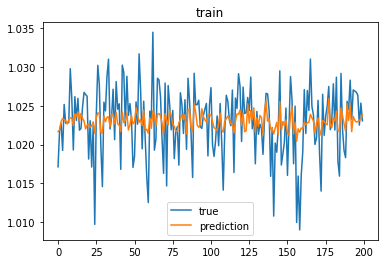

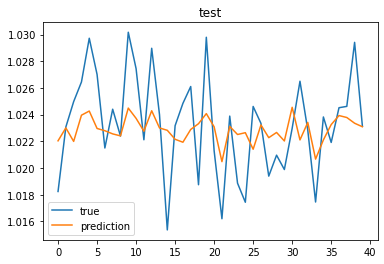

tensor([[ 0.4709, -0.1488, -0.7022,  0.1718, -0.0445, -0.2826,  0.2374, -0.0203,
         -0.4640,  0.5349, -0.0203,  0.3124,  0.8264, -0.3531,  0.3054, -0.0718,
         -0.2248, -0.0934],
        [ 0.4737, -0.1413, -0.6979,  0.1723, -0.0411, -0.2859,  0.2405, -0.0232,
         -0.4490,  0.5361, -0.0305,  0.3083,  0.8354, -0.3608,  0.2912, -0.0716,
         -0.2207, -0.0863],
        [ 0.4794, -0.1384, -0.6953,  0.1738, -0.0413, -0.2701,  0.2314, -0.0181,
         -0.4659,  0.5432, -0.0309,  0.3047,  0.8322, -0.3710,  0.3009, -0.0748,
         -0.2309, -0.1031],
        [ 0.4889, -0.1488, -0.6951,  0.1719, -0.0369, -0.2701,  0.2322, -0.0209,
         -0.4535,  0.5413, -0.0289,  0.3105,  0.8189, -0.3609,  0.2945, -0.0747,
         -0.2326, -0.0869],
        [ 0.4764, -0.1383, -0.7031,  0.1645, -0.0453, -0.2796,  0.2387, -0.0134,
         -0.4505,  0.5388, -0.0183,  0.3116,  0.8258, -0.3638,  0.2971, -0.0647,
         -0.2281, -0.0855],
        [ 0.4791, -0.1477, -0.6953,  0.1687, -0.03

In [9]:
tester = Tester(model,objective_env,
                 best_x,1e-2,
                 200,40)

test_data,pred_data = tester.run()
test_x,test_y,test_s = test_data
pred_y,lower,upper = pred_data
print(pred_y)
print(test_y)

In [8]:
config_file = "/home/q123/Desktop/explo/configs/swimmer.yaml"

with open(config_file, 'r') as f:
        cfg = yaml.load(f, Loader=yaml.Loader)

# Translate config dictionary.
cfg = insert(cfg, insertion_config)
model_config = cfg["optimizer_config"]["model_config"]
model_config

{'prior_mean': 0.0,
 'ard_num_dims': 'dim_search_space',
 'N_max': 32,
 'lengthscale_constraint': {'constraint': None, 'kwargs': None},
 'lengthscale_hyperprior': {'prior': gpytorch.priors.torch_priors.UniformPrior,
  'kwargs': {'a': 0.01, 'b': 0.3}},
 'outputscale_constraint': {'constraint': gpytorch.constraints.constraints.GreaterThan,
  'kwargs': {'lower_bound': 0.001}},
 'outputscale_hyperprior': {'prior': gpytorch.priors.torch_priors.NormalPrior,
  'kwargs': {'loc': 2.0, 'scale': 1.0}},
 'noise_constraint': {'constraint': None, 'kwargs': None},
 'noise_hyperprior': {'prior': None, 'kwargs': None}}